In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 1.x
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
import warnings 
warnings.filterwarnings("ignore")

from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications import *

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
import matplotlib.pyplot as plt
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(images_per_class[label][n])
            n += 1
    plt.show()

In [ ]:
x_train = []
x_test = []
y_train = []
label_map = {"pneumonia":0,"corona":1}

In [ ]:
from glob import glob
images_per_class = {}
for class_folder_name in tqdm(os.listdir("/content/drive/My Drive/dataset/train/")):
    class_folder_path = os.path.join("/content/drive/My Drive/dataset/train/", class_folder_name)
    class_label = class_folder_name
    images_per_class[class_label] = []
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images_per_class[class_label].append(image_bgr)

100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


In [ ]:
for key,value in images_per_class.items():
    print("{0} -> {1}".format(key, len(value)))

pneumonia -> 72
corona -> 22
.ipynb_checkpoints -> 0


pneumonia


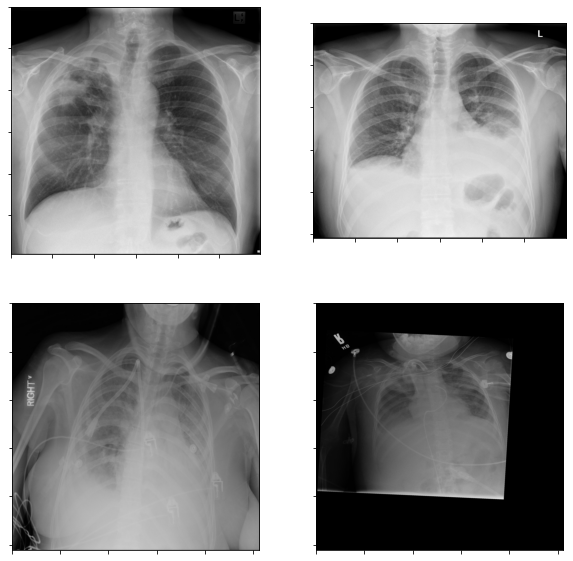

corona


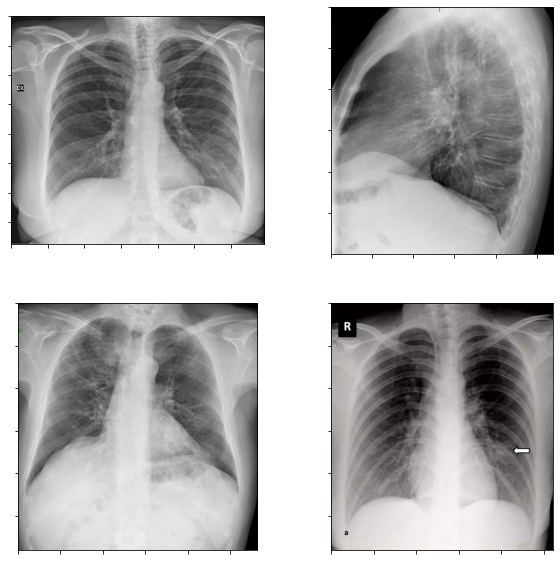

In [ ]:
for label in  label_map:
    print(label)
    plot_for_class(label)

In [ ]:
dim = 224

In [ ]:
dirs = os.listdir("/content/drive/My Drive/dataset/train/")
for k in range(len(dirs)):    # Directory
    files = os.listdir("/content/drive/My Drive/dataset/train/{}".format(dirs[k]))
    for f in tqdm(range(len(files))):     # Files
        img = cv2.imread('/content/drive/My Drive/dataset/train/{}/{}'.format(dirs[k], files[f]))
        targets = np.zeros(2)
        targets[label_map[dirs[k]]] = 1 
        x_train.append(cv2.resize(img, (dim, dim)))
        y_train.append(targets)

100%|██████████| 89/89 [00:03<00:00, 29.27it/s]
0it [00:00, ?it/s]


In [ ]:
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32)

print(x_train.shape)
print(y_train.shape)

(178, 224, 224, 3)
(178, 2)


In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.16, random_state=42) # Want a balanced split for all the classes
for train_index, test_index in sss.split(x_train, y_train):
    print("Using {} for training and {} for validation".format(len(train_index), len(test_index)))
    x_train, x_valid = x_train[train_index], x_train[test_index]
    y_train, y_valid = y_train[train_index], y_train[test_index]

Using 149 for training and 29 for validation


### Inception v3

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)                                      
weights = os.path.join('/content/drive/My Drive/dataset/', 'corona_weights.h5')

In [ ]:
epochs = 30
learning_rate = 0.0001
batch_size = 32

In [ ]:
callbacks = [ModelCheckpoint(weights, monitor='val_loss', save_best_only=True, verbose=0),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]

In [ ]:
base_model = InceptionV3(input_shape=(dim, dim, 3), include_top=False, weights='imagenet', pooling='avg') # Average pooling reduces output dimensions
x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])
model.summary()














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0       

In [ ]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train)/batch_size, 
                    validation_data=datagen.flow(x_valid, y_valid, batch_size=batch_size), 
                    validation_steps=len(x_valid)/batch_size,
                    callbacks=callbacks,
                    epochs=epochs, 
                    verbose=1)

Epoch 1/30
5/4 [================================] - 4s 706ms/step - loss: 0.0676 - acc: 0.9747 - val_loss: 0.3705 - val_acc: 0.8621
Epoch 2/30
5/4 [================================] - 4s 705ms/step - loss: 0.0818 - acc: 0.9629 - val_loss: 0.3744 - val_acc: 0.8276
Epoch 3/30
5/4 [================================] - 3s 688ms/step - loss: 0.0369 - acc: 0.9937 - val_loss: 0.3424 - val_acc: 0.7931
Epoch 4/30
5/4 [================================] - 4s 700ms/step - loss: 0.0998 - acc: 0.9692 - val_loss: 0.4869 - val_acc: 0.8276
Epoch 5/30
5/4 [================================] - 3s 693ms/step - loss: 0.0616 - acc: 0.9692 - val_loss: 0.4541 - val_acc: 0.8276
Epoch 6/30
5/4 [================================] - 3s 690ms/step - loss: 0.0303 - acc: 1.0000 - val_loss: 0.5266 - val_acc: 0.8276
Epoch 7/30
5/4 [================================] - 3s 690ms/step - loss: 0.0485 - acc: 0.9810 - val_loss: 0.4136 - val_acc: 0.7931
Epoch 8/30
5/4 [================================] - 3s 689ms/step - loss: 0.

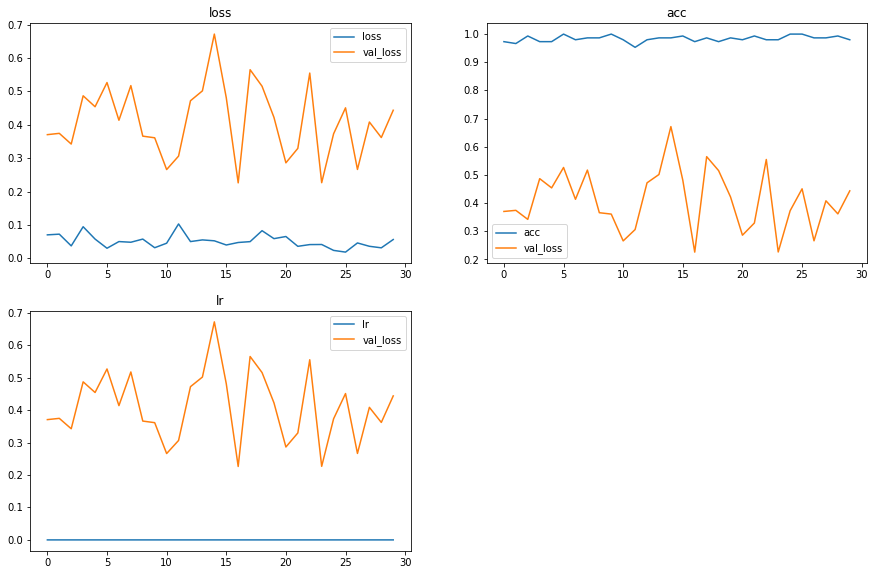

In [ ]:
import matplotlib.pyplot as plt
def plot_model(model):
    plots = [i for i in model.history.history.keys() if i.find('val_') == -1]
    plt.figure(figsize=(15,15))

    for i, p in enumerate(plots):
        plt.subplot(len(plots), 2, i + 1)
        plt.title(p)
        plt.plot(model.history.history[p], label=p)
        plt.plot(model.history.history['val_loss'], label='val_loss')
        plt.legend()

    plt.show()
    
plot_model(model)